<a href="https://colab.research.google.com/github/staceyland/BTC_prediction/blob/main/BTC_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's set up the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

I will analyze Bitcoin against the US dollar.

In [4]:
crypto_currency = 'BTC'
against_currency = 'USD'

I will import data from January 1, 2020 until today from Yahoo finance.

In [5]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

In [6]:
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

Let's take a peek at the data.

In [7]:
# Prepare Data
print(data.head())

                   High          Low  ...        Volume    Adj Close
Date                                  ...                           
2020-01-01  7254.330566  7174.944336  ...  1.856566e+10  7200.174316
2020-01-02  7212.155273  6935.270020  ...  2.080208e+10  6985.470215
2020-01-03  7413.715332  6914.996094  ...  2.811148e+10  7344.884277
2020-01-04  7427.385742  7309.514160  ...  1.844427e+10  7410.656738
2020-01-05  7544.497070  7400.535645  ...  1.972507e+10  7411.317383

[5 rows x 6 columns]


We will use the previous 60 days to predict price then train.

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


prediction_days = 60

In [9]:
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Let's create the neural network.

In [10]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
19/19 [==============================] - 7s 90ms/step - loss: 0.0599
Epoch 2/25
19/19 [==============================] - 2s 93ms/step - loss: 0.0092
Epoch 3/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0076
Epoch 4/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0074
Epoch 5/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0066
Epoch 6/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0063
Epoch 7/25
19/19 [==============================] - 2s 93ms/step - loss: 0.0065
Epoch 8/25
19/19 [==============================] - 2s 93ms/step - loss: 0.0067
Epoch 9/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0056
Epoch 10/25
19/19 [==============================] - 2s 92ms/step - loss: 0.0055
Epoch 11/25
19/19 [==============================] - 2s 90ms/step - loss: 0.0047
Epoch 12/25
19/19 [==============================] - 2s 91ms/step - loss: 0.0050
Epoch 13/25
19/19 [==================

Let's test and create the dataset.

In [11]:
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [12]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)


In [13]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [14]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

Now let's plot the data. Actual prices are shown against predicted prices. It's not perfect but it shows a trend.

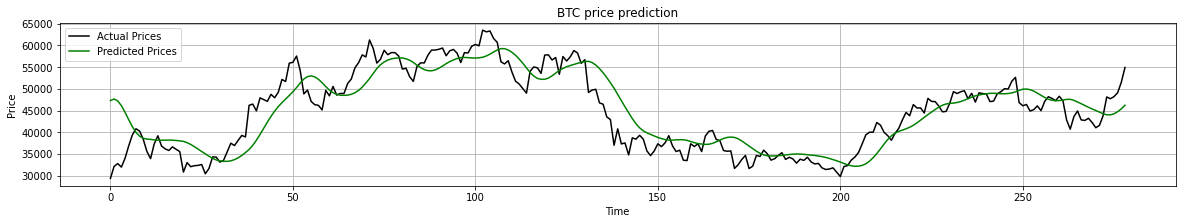

In [28]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.plot(figsize=(16,8))
plt.grid()
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

We can try to predict tomorrow's price. Let's see what happens. The calculation was done on 10/6/21 10:49pm.

In [33]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)


[[47285.48]]
